# 2D Gaussian Process Classification via Spatio-Temporal Kalman Smoothing

## Import and load data

banana data loaded


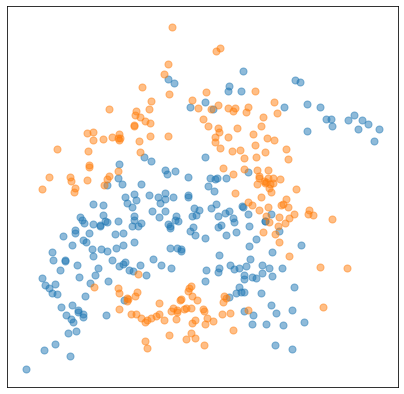

In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
from jax.experimental import optimizers
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv, ListedColormap
from scipy.interpolate import interp1d
import time
from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot_2d_classification

inputs = np.loadtxt('../../data/banana_X_train', delimiter=',')
X = inputs[:, :1]  # temporal inputs (x-axis)
R = inputs[:, 1:]  # spatial inputs (y-axis)
Y = np.loadtxt('../../data/banana_Y_train')[:, None]  # observations / labels
print('banana data loaded')

# Test points
Xtest, Rtest = np.mgrid[-2.8:2.8:100j, -2.8:2.8:100j]

np.random.seed(99)
N = X.shape[0]  # number of training points

plt.figure(1, figsize=(7, 7))
for label, mark in [[1, 'o'], [0, 'o']]:
    ind = Y[:, 0] == label
    plt.scatter(X[ind], R[ind], s=50, alpha=.5)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

## Build the GP model

In [2]:
var_f = 0.3  # GP variance
len_time = 0.3  # temporal lengthscale
len_space = 0.3  # spacial lengthscale

prior = priors.SpatioTemporalMatern52(variance=var_f, lengthscale_time=len_time, lengthscale_space=len_space)
lik = likelihoods.Probit()
inf_method = approx_inf.ExpectationPropagation(power=0.5)
# inf_method = approx_inf.StatisticallyLinearisedEP()
# inf_method = approx_inf.ExtendedKalmanSmoother()
# inf_method = approx_inf.VariationalInference()

model = SDEGP(prior=prior, likelihood=lik, t=X, y=Y, r=R, approx_inf=inf_method)

/Users/wilkinw1/Library/Python/3.7/lib/python/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


building SDE-GP with Spatio-Temporal Matern-5/2 prior and Bernoulli likelihood ...
inference method is Expectation Propagation (EP)


## Set up the optimiser

In [3]:
opt_init, opt_update, get_params = optimizers.adam(step_size=2e-1)
# parameters should be a 2-element list [param_prior, param_likelihood]
opt_state = opt_init([model.prior.hyp, model.likelihood.hyp])


def gradient_step(i, state, mod):
    params = get_params(state)
    mod.prior.hyp = params[0]
    mod.likelihood.hyp = params[1]

    # grad(Filter) + Smoother:
    neg_log_marg_lik, gradients = mod.run()
    # neg_log_marg_lik, gradients = mod.run_two_stage()  # <-- less elegant but reduces compile time

    prior_params = softplus_list(params[0])
    if (i % 10) == 0:
        print('iter %2d: var=%1.2f len_time=%1.2f len_space=%1.2f, nlml=%2.2f' %
              (i, prior_params[0], prior_params[1], prior_params[2], neg_log_marg_lik))

    return opt_update(i, gradients, state)

## Optimise the hyperparameters and site parameters

In [4]:
print('optimising the hyperparameters ...')
t0 = time.time()
for j in range(200):
    opt_state = gradient_step(j, opt_state, model)
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

optimising the hyperparameters ...
iter  0: var=0.30 len_time=0.30 len_space=0.30, nlml=178.81
iter 10: var=1.23 len_time=0.96 len_space=0.62, nlml=128.56
iter 20: var=2.57 len_time=0.83 len_space=0.49, nlml=117.43
iter 30: var=3.63 len_time=0.89 len_space=0.59, nlml=114.33
iter 40: var=4.42 len_time=1.02 len_space=0.56, nlml=112.71
iter 50: var=5.05 len_time=0.97 len_space=0.59, nlml=111.86
iter 60: var=5.57 len_time=1.03 len_space=0.58, nlml=111.19
iter 70: var=6.04 len_time=1.03 len_space=0.59, nlml=110.70
iter 80: var=6.47 len_time=1.05 len_space=0.59, nlml=110.32
iter 90: var=6.88 len_time=1.07 len_space=0.60, nlml=109.97
iter 100: var=7.26 len_time=1.08 len_space=0.60, nlml=109.69
iter 110: var=7.64 len_time=1.09 len_space=0.61, nlml=109.42
iter 120: var=8.00 len_time=1.10 len_space=0.61, nlml=109.20
iter 130: var=8.35 len_time=1.11 len_space=0.61, nlml=108.99
iter 140: var=8.69 len_time=1.12 len_space=0.61, nlml=108.80
iter 150: var=9.03 len_time=1.13 len_space=0.62, nlml=108.63

## Make predictions

In [5]:
print('calculating the posterior predictive distribution ...')
t0 = time.time()
mu, var = model.predict(t=Xtest, r=Rtest)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))

calculating the posterior predictive distribution ...
prediction time: 3.27 secs


## Plot decision boundary

plotting ...


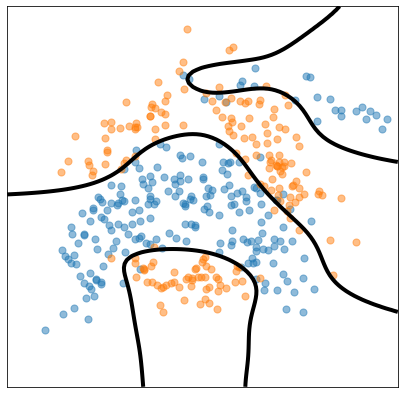

In [6]:
link_fn = model.likelihood.link_fn

print('plotting ...')
plt.figure(2, figsize=(7, 7))
for label, mark in [[1, 'o'], [0, 'o']]:
    ind = Y[:, 0] == label
    plt.scatter(X[ind], R[ind], s=50, alpha=.5)
plt.contour(Xtest, Rtest, mu, levels=[.0], colors='k', linewidths=4.)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
lim = 2.8
plt.xlim([-lim, lim])
plt.ylim([-lim, lim]);

## Plot posterior mean using colour map

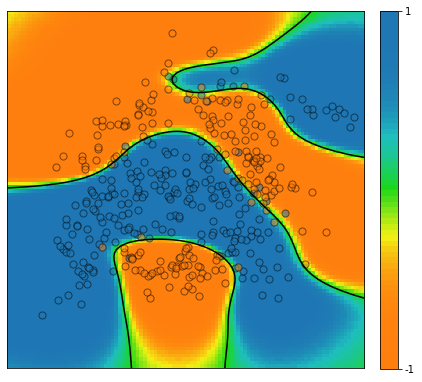

In [7]:
cmap_ = [[1, 0.498039215686275, 0.0549019607843137], [0.12156862745098, 0.466666666666667, 0.705882352941177]]
cmap = hsv_to_rgb(interp1d([0., 1.], rgb_to_hsv(cmap_), axis=0)(link_fn(np.linspace(-3.5, 3.5, num=64))))
newcmp = ListedColormap(cmap)

plt.figure(3, figsize=(7, 7))
im = plt.imshow(link_fn(mu).T, cmap=newcmp, extent=[-lim, lim, -lim, lim], origin='lower')
cb = plt.colorbar(im, fraction=0.0458, pad=0.04)
cb.set_ticks([cb.vmin, 0, cb.vmax])
cb.set_ticklabels([-1, 0, 1])
plt.contour(Xtest, Rtest, mu, levels=[.0], colors='k', linewidths=1.5)
for label in [1, 0]:
    ind = Y[:, 0] == label
    plt.scatter(X[ind], R[ind], s=50, alpha=.5, edgecolor='k')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim);